Check Python version

In [241]:
!python --version

Python 3.10.14


Import libraries

In [242]:
import json
import yaml
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

### **Extract Data**

In [243]:
# Through online GitHub
file_name = 'https://github.com/ourownstory/neuralprophet-data/raw/main/datasets/air_passengers.csv'

In [244]:
train_df = pd.read_csv(file_name)

In [245]:
train_df.shape

(144, 2)

In [246]:
train_df.columns

Index(['ds', 'y'], dtype='object')

In [247]:
train_df.head()

,ds,y
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121


In [248]:
train_df.tail()

,ds,y
139,1960-08-01,606
140,1960-09-01,508
141,1960-10-01,461
142,1960-11-01,390
143,1960-12-01,432


Define the required time and target columns

In [249]:
time_col = train_df.columns[0]
target_col = train_df.columns[-1]
train_df[time_col] = train_df[time_col].astype(str)

Change target column to float

In [250]:
train_df[target_col] = train_df[target_col].astype(float)

In [251]:
train_df.head()

,ds,y
0,1949-01-01,112.0
1,1949-02-01,118.0
2,1949-03-01,132.0
3,1949-04-01,129.0
4,1949-05-01,121.0


Plot graph

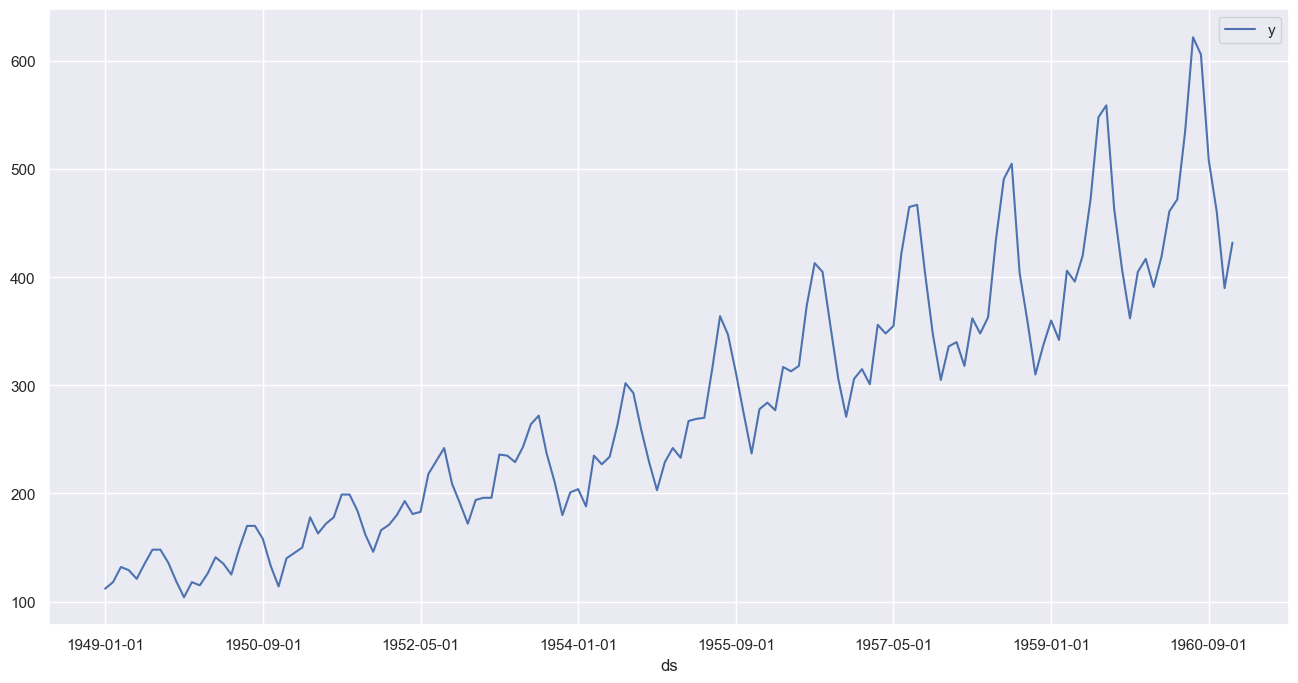

In [252]:
figsize = (16, 8)
train_df.set_index(time_col).plot(figsize=figsize);

### **Train API**

Train data: convert df to list-of-list

In [253]:
train_data = []

In [254]:
for value in train_df.values:
    train_data.append(list(value))

In [255]:
train_data[:10]

[['1949-01-01', 112.0],
 ['1949-02-01', 118.0],
 ['1949-03-01', 132.0],
 ['1949-04-01', 129.0],
 ['1949-05-01', 121.0],
 ['1949-06-01', 135.0],
 ['1949-07-01', 148.0],
 ['1949-08-01', 148.0],
 ['1949-09-01', 136.0],
 ['1949-10-01', 119.0]]

Define Model Request (optional)

In [256]:
# # Default model request
# model_request = {
#     'type': 'meta_wa',
#     'scorers': ['smape', 'mase'],
#     'params': {
#         'preprocessors': [
#             {'type': 'dartsimputer'},
#             {'type': 'minmaxscaler'},
#         ],
#         'base_models': [
#             # {'type': 'darts_naive'},
#             {'type': 'darts_seasonalnaive'},
#             # {'type': 'darts_autotheta'},
#             # {'type': 'darts_autoarima'},
#             # {'type': 'darts_autoets'},
#         ],
#     },
# }

# # # Onboard NeuralProphet customized model request
# # np_external_model_request = {
# #     'params': {
# #       'changepoints_range': 0.2,
# #       'epochs': 2,
# #       'growth': 'off'
# #     },
# #     'metrics': [],
# #     'type': 'neuralprophet',
# # }
# # # np_external_model_request = None

# user_value = 0.9
# output_type = 'estimate'  # 'data', 'estimate'
# mauq_external_params = {
#     'problem_type': 'regression',
#     'confidence_level': user_value,
#     'output_type': output_type

# }

# deepsybil_external_model_request = {
#     'type': 'meta_wa',  # 'meta_naive', 'meta_wa'
#     'scorers': ['mase', 'smape'],
#     'params': {
#         'preprocessors': [
#             # {'type': 'dartsimputer'},
#             # {'type': 'simpleimputer', 'params': {'strategy': 'mean'}},
#             {'type': 'minmaxscaler'},
#         ],
#         'base_models': [
#             # {'type': 'darts_rnn',
#             #  'params': {
#             #      'model': 'LSTM',
#             #      'hidden_dim': 10,
#             #      'n_rnn_layers': 3
#             # }},
#             # {'type': 'darts_tcn',
#             #  'params': {
#             #      'output_chunk_length': 52,
#             #      'input_chunk_length': 104,                 
#             #      'n_epochs': 20,
#             # }},
#             # {'type': 'darts_rnn',
#             #  'params': {
#             #      'model': 'LSTM',
#             #      'hidden_dim': 10,
#             #      'n_rnn_layers': 3
#             # }},
#             {'type': 'darts_nlinear'},
#             {'type': 'darts_dlinear'},
#             # {'type': 'darts_blockrnn'},
#             # {'type': 'darts_tsmixer',
#             #  'params': {
#             #      'output_chunk_length': 52,
#             #      'input_chunk_length': 104,                 
#             #      'n_epochs': 20,
#             # }},
#             #  {'type': 'darts_tide'}
#         ],
#     },
# }


# # # Customized model request
# model_request = {
#     'type': 'meta_wa',  # 'meta_naive', 'meta_wa'
#     'scorers': ['mase', 'smape'],
#     'params': {
#         'preprocessors': [
#             {'type': 'dartsimputer'},
#             {'type': 'simpleimputer', 'params': {'strategy': 'mean'}},
#             {'type': 'minmaxscaler'},
#         ],
#         'base_models': [
#             {'type': 'darts_naive'},
#             # {'type': 'darts_seasonalnaive'},
#             # {'type': 'darts_autotheta'},
#             # {'type': 'stats_autotheta'},
#             # {'type': 'darts_autoets'},
#             # {'type': 'stats_autoets'},
#             # {'type': 'darts_autoarima'},
#             # {'type': 'stats_autoarima'},
#             # {'type': 'darts_autoces'},
#             # {'type': 'darts_kalman'},
#             # {'type': 'darts_catboost'},            
#             # # {'type': 'darts_tbats'},
#             # # {'type': 'darts_linearregression'},
#             # {'type': 'darts_lightgbm',
#             #  'params': {
#             #      'lags': 12,
#             #      'output_chunk_length': 6,
#             #      'verbose': -1
#             # }}
#             # {'type': 'neuralprophet',
#             #  'external_params': np_external_model_request
#             # }  # Onboard NeuralProphet external service
#             # {'type': 'deepsybil',
#             #  'external_params': deepsybil_external_model_request
#             # }  # Onboard NeuralProphet external service
#         ],
        
#     },
#     'mauq_params':mauq_external_params,
# }

This is for JSON model_request

In [257]:
# file_path = 'model_request.json'
# # For writing the model request to a json file
# with open(file_path, 'r') as file:
#     model_request = json.load(file)

This is for YAML model_request

In [258]:
file_path = 'model_request.yaml'
# For reading the model request from a yaml file
with open(file_path, 'r') as file:
    model_request = yaml.safe_load(file)

Train API JSON Payload

In [259]:
api_json = {
    'data': train_data,
    'model': model_request  # (optional) can be commented out
}

In [260]:
api_json['model']

{'type': 'meta_lr',
 'scorers': ['mase', 'smape'],
 'params': {'preprocessors': [{'type': 'dartsimputer'},
   {'type': 'minmaxscaler'}],
  'base_models': [{'type': 'deepsybil',
    'external_params': {'type': 'meta_wa',
     'scorers': ['mase', 'smape'],
     'params': {'preprocessors': [{'type': 'minmaxscaler'}],
      'base_models': [{'type': 'darts_nlinear'},
       {'type': 'darts_dlinear'}]}}}]},
 'mauq_params': {'problem_type': 'regression',
  'confidence_level': 0.9,
  'output_type': 'estimate'}}

Build URL

In [261]:
with open('url.yaml', 'r') as file:
    url_dict = yaml.safe_load(file)

In [262]:
# URL to our SYBIL AWS service
protocol = url_dict['protocol']
host = url_dict['host']
port = url_dict['port']
endpoint = 'train'

url = '%s://%s:%s/%s' % (protocol, host, str(port), endpoint)

In [263]:
# protocol, host, port

Call endpoint, receive response JSON, write to output file

In [264]:
# %%time
# print("Hello")
response = requests.post(url, json=api_json)
# print(response)
# print()

In [265]:
train_json_out = response.json()  # dict output
train_json_out
# response.json()


{'model': 'AgEBCCffAQAg3wEAHNsBABgAAAAR2wEA5DsAAIAAZWxpk4xvlGxvjG2UBGFplHNyYZQojC50bZRNk3BveJRJjC5kbUlljBVvaQx0jIx5QygklIkDSv9DbpRkLi5ld22TdGQoZHOUX2V5k2FhYZRplE4CUk7/KEt0AJRoiGj/AJSUgMbEAwFqaNHOzDUynJmX19Q9O6ShnwgGb2xqqqcQDnd1ctvZQj89Eg94dt/c2kNBqqel5eJLSbKwrRYUfXp4uLUeHIWDgOnnUE5Li4ny71hWU726IyEe8/BZV8C+uyQii4iGxsQtKpORjvf1XlxZmZcA/WZkYsvIMS8sbGrT0To3NZ6bBAIA1NI7OKGfnQYDbH1xNXVSlHJtlHJmjF90c2hhlCgAAWhhAlJO/2IAjHUAUm9vZGV0UpRfXWVylA9plHNhbQlJYWyUcGFjlJSUbXBzfW5lYWxoc3INbGVlc3NdZXRhjJNpjGdoZ1ExUUEyR21YWkhIM0YySDJJV0dZQXdKV1dtWG5ucG5BWmpGQWt2SEFBSTV3QUZBSkcyWElVMFoyV0ZBMVhaWUhXbVdXQVdXWkYyR0JTMjJsR0dwVjUxMkczRkEyR1Y1WElHbUg1bVpaNVVCSUNrLzBVKzBMODlwclovTnlWbXZZdm5CNWloYTNpdVRnYkdEYzZ2ZUwwOHUwUUFYQ0lPSENNSmo2RUtCU1FNbnlXYU9lNU8ybmlQMlRkd3BBckFpb2krUVUwR1FnNGxBK3U4RzVqekZYUDB6Vk13VXRuTDJUaWg3MHdETUtIYmVYNjBQZjBqQ2puZkZUY0N1WTBWZ2dEWFJlY2FrSVQ5TkErNE1aU0VKMVJmSFN3VWlEbGdRYmpRZHI3UDhXaVllYUoxZEgrcVlwelhUSE9sOXBVekFMZ04rRE43QnY5MkVGNWxnSTJVSDg4eDF2L1dSbllUcjJ1eUNHQ285RDI1Y2toTDhJSjUxLzR3SHZPW

In [266]:
estimate=train_json_out['estimate']

### **Forecast API**

Forecast Dates: predict the next 2 years of air passenger data (1961-1962)

In [267]:
dates = [
    '1961-01-01', '1961-02-01', '1961-03-01', '1961-04-01', '1961-05-01', '1961-06-01',
    '1961-07-01', '1961-08-01', '1961-09-01', '1961-10-01', '1961-11-01', '1961-12-01',
    '1962-01-01', '1962-02-01', '1962-03-01', '1962-04-01', '1962-05-01', '1962-06-01',
    '1962-07-01', '1962-08-01', '1962-09-01', '1962-10-01', '1962-11-01', '1962-12-01',
]

Model from Train API

In [268]:
model = train_json_out['model']

Forecast API JSON Payload

In [269]:
api_json = {
    'model': model,
    'data': dates,
    'estimate' : estimate
}

Build URL (same as train except for the endpoint)

In [270]:
endpoint = 'forecast'

url = '%s://%s:%s/%s' % (protocol, host, str(port), endpoint)

Call endpoint, receive response JSON, write to output file

In [271]:
%%time
response = requests.post(url, json=api_json,verify=False)
print(response)
print()

<Response [200]>

CPU times: total: 0 ns
Wall time: 2.96 s


In [272]:
forecast_json_out = response.json()  # dict output
forecast_json_out

{'data': [['1961-01-01',
   439.63227206818925,
   364.31488077866516,
   514.9496633577133],
  ['1961-02-01', 420.0869499525479, 344.76955866302376, 495.40434124207206],
  ['1961-03-01', 438.27940572605706, 362.96201443653297, 513.5967970155812],
  ['1961-04-01', 476.93437223332995, 401.61698094380586, 552.251763522854],
  ['1961-05-01', 516.6981020942063, 441.38071080468217, 592.0154933837305],
  ['1961-06-01', 584.6241692014006, 509.30677791187645, 659.9415604909248],
  ['1961-07-01', 664.7993629855099, 589.4819716959857, 740.116754275034],
  ['1961-08-01', 644.7861030266987, 569.4687117371745, 720.1034943162229],
  ['1961-09-01', 560.2898171959024, 484.97242590637825, 635.6072084854266],
  ['1961-10-01', 485.4422470210251, 410.12485573150093, 560.7596383105492],
  ['1961-11-01', 427.1810503424803, 351.8636590529562, 502.4984416320044],
  ['1961-12-01', 447.6705157664485, 372.35312447692434, 522.9879070559726],
  ['1962-01-01', 473.38224089712475, 398.06484960760065, 548.69963218664

Combine forecast dates and output

In [273]:
forecast_df = pd.DataFrame(
    data=forecast_json_out['data'],
    columns=[time_col, target_col,"lower_interval","upper_interval"],
)

In [274]:
forecast_df.shape

(24, 4)

In [275]:
forecast_df.columns

Index(['ds', 'y', 'lower_interval', 'upper_interval'], dtype='object')

In [276]:
forecast_df.head()

,ds,y,lower_interval,upper_interval
0,1961-01-01,439.632272,364.314881,514.949663
1,1961-02-01,420.086950,344.769559,495.404341
2,1961-03-01,438.279406,362.962014,513.596797
3,1961-04-01,476.934372,401.616981,552.251764
4,1961-05-01,516.698102,441.380711,592.015493


In [277]:
forecast_df.tail()

,ds,y,lower_interval,upper_interval
19,1962-08-01,703.859234,628.541843,779.176625
20,1962-09-01,617.179639,541.862248,692.497030
21,1962-10-01,533.991241,458.673850,609.308633
22,1962-11-01,472.845836,397.528445,548.163228
23,1962-12-01,486.030950,410.713559,561.348341


Plot train and forecast side-by-side

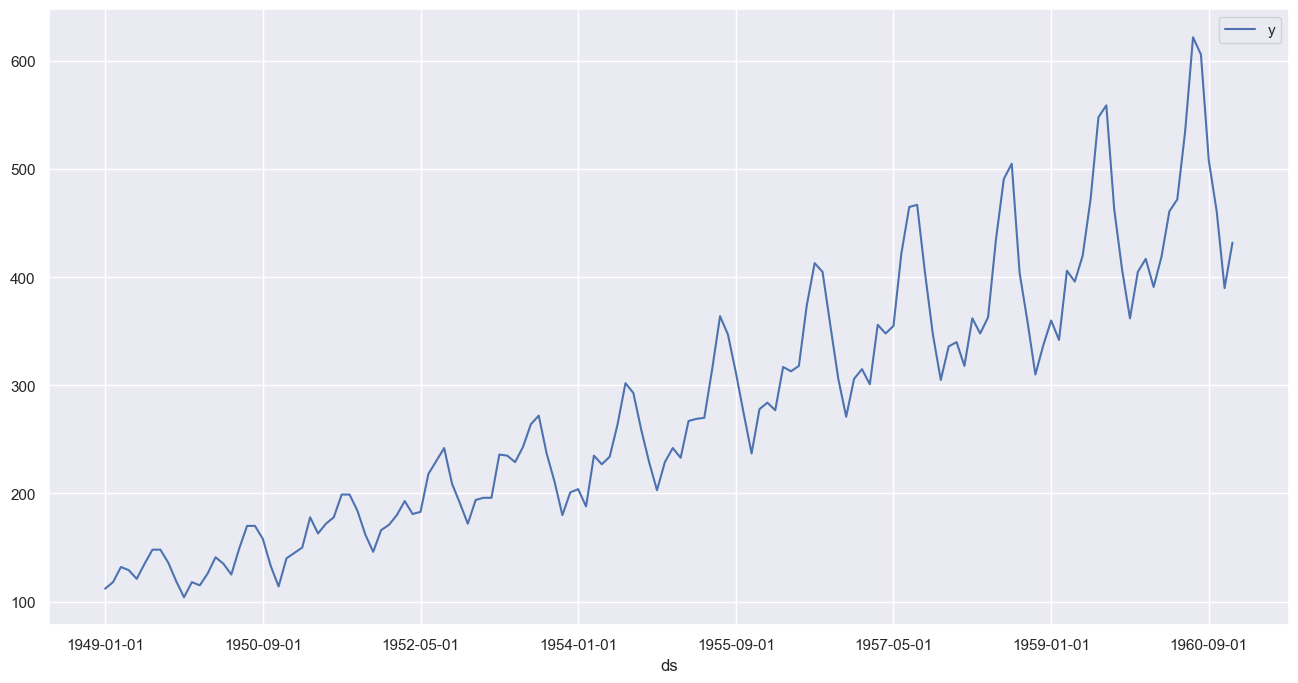

In [278]:
train_df['color'] = 'b'
train_df.set_index(time_col).plot(figsize=figsize, color=train_df['color']);

Combine train and forecast sets

In [279]:
df = pd.concat([train_df, forecast_df]).reset_index(drop=True)

In [280]:
df.shape

(168, 5)

In [281]:
df.head()

,ds,y,color,lower_interval,upper_interval
0,1949-01-01,112.0,b,NaN,NaN
1,1949-02-01,118.0,b,NaN,NaN
2,1949-03-01,132.0,b,NaN,NaN
3,1949-04-01,129.0,b,NaN,NaN
4,1949-05-01,121.0,b,NaN,NaN


In [282]:
df.tail()

,ds,y,color,lower_interval,upper_interval
163,1962-08-01,703.859234,NaN,628.541843,779.176625
164,1962-09-01,617.179639,NaN,541.862248,692.497030
165,1962-10-01,533.991241,NaN,458.673850,609.308633
166,1962-11-01,472.845836,NaN,397.528445,548.163228
167,1962-12-01,486.030950,NaN,410.713559,561.348341


Plot combined train and forecast sets with the vertical black line as the cut-off

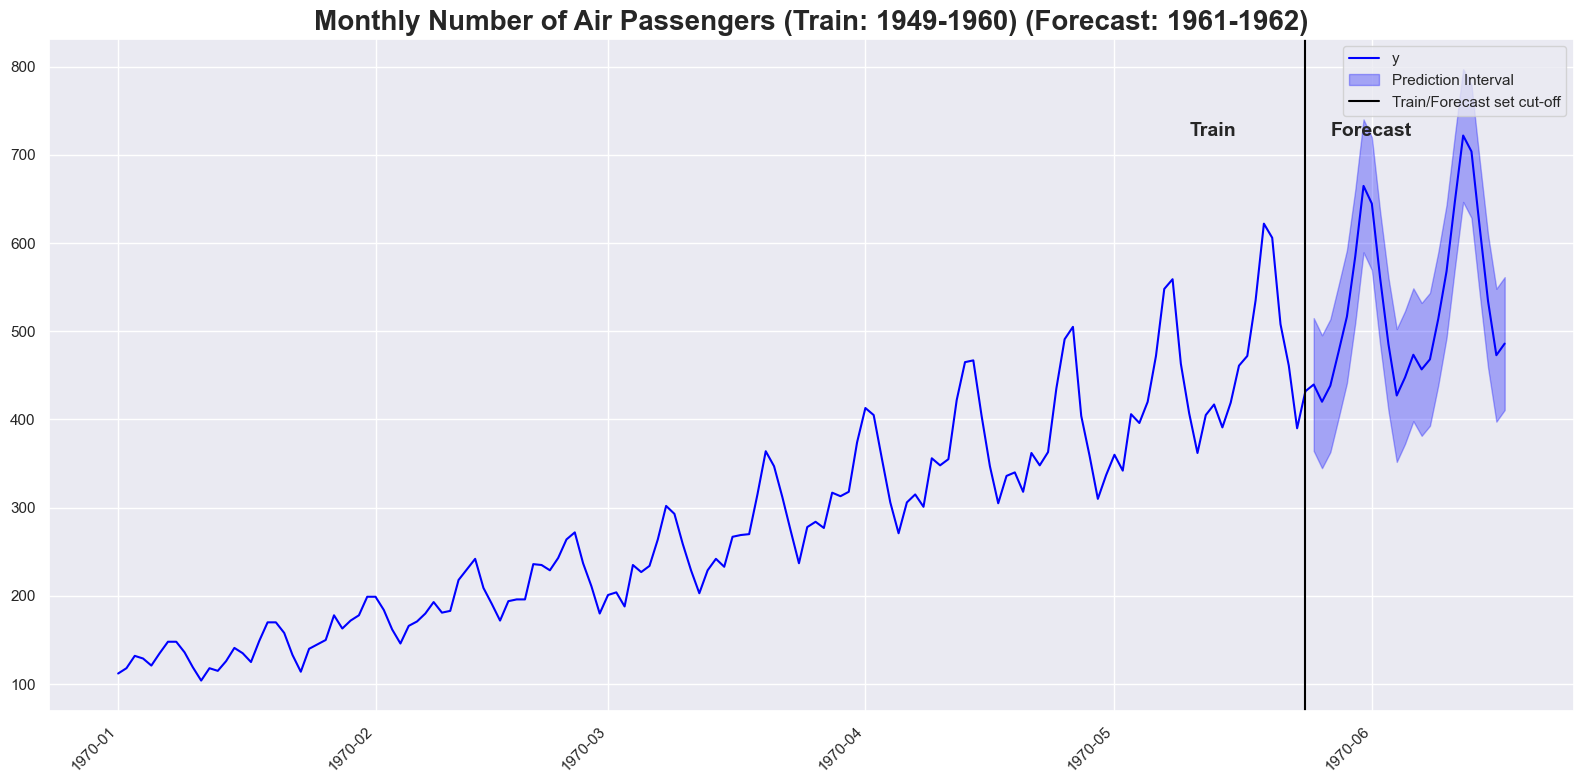

In [301]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.figure(figsize=figsize)

plt.plot(df[time_col], df[target_col], color='blue', label='y')
# plt.plot(forecast_df[time_col], forecast_df[target_col], color='blue', linestyle='dashed', label='Forecast')
plt.fill_between(forecast_df[time_col], forecast_df['lower_interval'], forecast_df['upper_interval'], 
                 color='blue', alpha=0.3, label='Prediction Interval')
plt.axvline(x=df[time_col].iloc[len(train_df)-1], color='black', label='Train/Forecast set cut-off')

plt.text(df[time_col].iloc[len(train_df)-15], df[target_col].max(), 'Train', fontweight='bold', fontsize=14)
plt.text(df[time_col].iloc[len(train_df)+2], df[target_col].max(), 'Forecast', fontweight='bold', fontsize=14)

plt.title('Monthly Number of Air Passengers (Train: 1949-1960) (Forecast: 1961-1962)', fontweight='bold', fontsize=20)
plt.legend()

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.setp(ax.get_xticklabels(), rotation=45, ha="right") 
plt.tight_layout()
plt.show()

